In [3]:
import matplotlib.pyplot as plt
from scipy.signal import lti
import numpy as np
from numpy import pi, sin, cos
from scipy.integrate import odeint
import control

In [4]:
def Plot_state(x,dx,th,dth,t):
    fig, axs = plt.subplots(2, 2, figsize = (12,10))
    axs[0,0].plot(t, x)
    axs[0,0].set_xlabel('time')
    axs[0,0].set_ylabel('position')
    axs[0,0].set_title("Position of Cart")
    axs[0,0].grid(True)

    axs[0,1].plot(t, dx)
    axs[0,1].set_xlabel('time')
    axs[0,1].set_ylabel('velocity')
    axs[0,1].set_title("Velocity Cart")
    axs[0,1].grid(True)

    axs[1,0].plot(t, th)
    axs[1,0].set_xlabel('time')
    axs[1,0].set_ylabel('angle')
    axs[1,0].set_title("Angle of Pendulum")
    axs[1,0].grid(True)

    axs[1,1].plot(t, dth)
    axs[1,1].set_xlabel('time')
    axs[1,1].set_ylabel('omega')
    axs[1,1].set_title("Omega of Pendulum")
    axs[1,1].grid(True)

<h3> Non linear modelling of Inverted Pendulum with motor control

In [7]:
# physical constants
M = 0.5;
m = 0.2;
b = 0.2;
I = 0.0034;
g = 9.8;
l = 0.3;

#motor parameter
k = 0.5 # motor torque constant
R = 6.5 # motor resistance
r = 0.05   # shaft radius
J = 0.0001
b = 0.1
L = 2.7*10**(-6)

In [8]:
# simulation time
x0 = np.array([0.0,0.0,0.0,0.0])
dt = 0.0001
Tmax = 100
t = np.arange(0.0, Tmax, dt)

In [9]:
V = 1
def Force_input(t,V,dx):
    if t >0 and t<0.1:
        F = k * V / (R * r) -  dx*(k * k )/ (R * r *r ) 
    else:
        F = 0
    return F

In [10]:
def pendulum(ds, t):
    x,dx,th,dth = ds
    F = Force_input(t,V,dx)
    x_dot = dx 
    D = (M+m)*(I+m*l*l) - (m*l*cos(th))**2
    dx_dot = ((I+m*l*l)*(F + m*l*dth*dth*sin(th)-b*dx) + (m*g*l*sin(th))*(m*l*cos(th)))/D
    th_dot = dth
    dth_dot = (-(M+m)*(m*g*l*sin(th))- m*l*cos(th)*(F + m*l*dth*dth*sin(th) - b*dx))/D
    return np.array([x_dot,dx_dot,th_dot,dth_dot])


In [11]:
sol = odeint(pendulum, x0, t)
sol = np.transpose(sol)
x, dx, th, dth  = sol

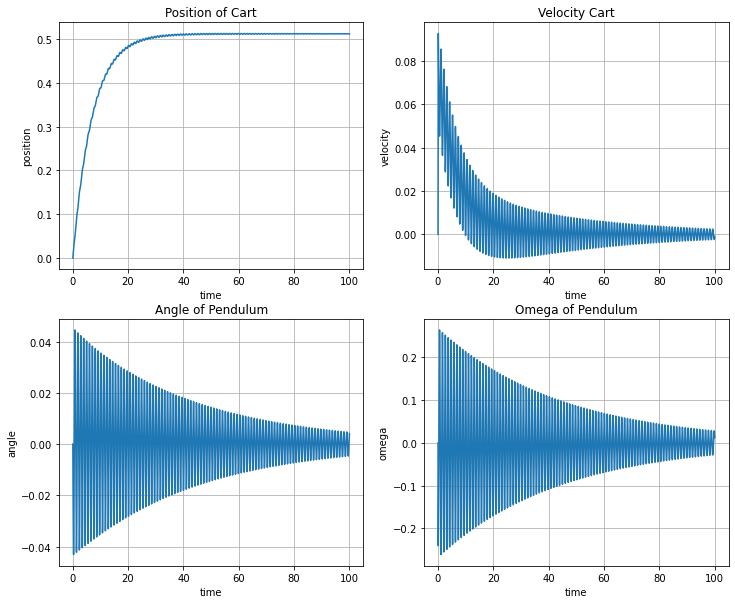

In [12]:
Plot_state(x,dx,th,dth,t)

<h3> Linearization of non linear pendulum model </h3>
    Linearization has been performed about angle $\pi$. The angle for vertical is 0.

In [13]:
p = I*(M+m)+M*m*l**2;


A = np.array([[0   ,   1    ,          0   ,        0],
              [0 , -(I+m*l**2)*b/p , (m**2*g*l**2)/p ,  0],
              [0 ,     0         ,     0    ,       1],
              [0 , -(m*l*b)/p   ,    m*g*l*(M+m)/p , 0]])

B = np.array([[0],
          [(I+m*l**2)/p],
          [0],
          [m*l/p]])
C = np.array([[1 ,0 ,0 ,0],
              [0 ,1 ,0 ,0],
              [0 ,0 ,1 ,0],
              [0 ,0 ,0 ,1]])
D = np.array([[0],
     [0],
     [0],
     [0]])

pendulum = lti(A,B,C,D)

In [14]:
time = np.linspace(0,1,1000)
t,y = pendulum.step(X0=0, T= time)
x,dx,th,dth = np.transpose(y)

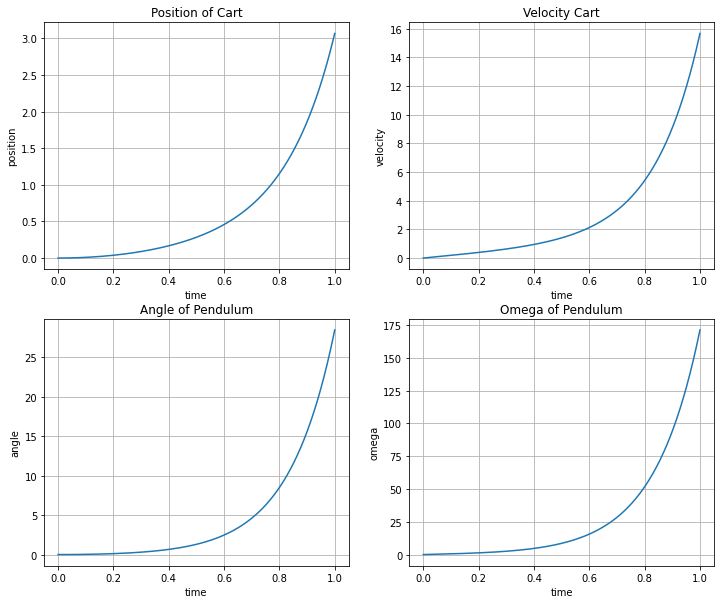

In [15]:
Plot_state(x,dx,th,dth,t)

In [29]:
#from ctms engin umic edu
class Motor:
    def __init__(self, J,b,R,L,k,r):
        self.J = J
        self.b = b 
        self.R = R
        self.L = L
        self.k = k
        self.r = r
        self.state = np.array([0,0,0])
        self.change_input(0.0,0.0)
        self.change_state(self.state)

    def change_input(self,u,dx):
        self.V = u
        self.dx = dx

    def change_state(self,x):
        self.th = x[0]
        self.dth = x[1]
        self.i = x[2]
        self.output = self.Force(self.r,self.dx)
        self.state = np.array([self.th,self.dth, self.i])
    
    def derivative(self,V,dx):
        self.change_input(V,dx)
        th_dot = self.dth
        dth_dot = (-self.b/self.k)*self.dth + (self.k/self.J)*self.i
        i_dot = (-self.k/self.L)*self.th - (self.R/self.L)*self.i + (1/self.L)*self.V
        return np.array([th_dot,dth_dot,i_dot])

    def Force(self,r,dx): #calculated the linear force
        return k*self.V/(self.R*r) - dx*(self.k*self.k)/(self.R*r*r)

In [30]:
#from ctms engin umic edu
class Pendulum_Non_Linear:
    def __init__(self):
        self.state = np.array([0,0,pi + pi/20,0])
        self.change_state(self.state)
        self.change_input(0)

    def change_input(self,x):
        self.V = x

    def change_state(self,x):
        self.x = x[0]
        self.dx = x[1]
        self.th = x[2]
        self.dth = x[3]
        self.output = [self.x,self.dx, self.th,self.dth]
        self.state = np.array([self.x, self.dx, self.th, self.dth])
    
    def derivative(self,F):
        self.change_input(F)
        x_dot = self.dx
        D = (M+m)*(I+m*l*l) - (m*l*cos(self.th))**2
        dx_dot = ((I+m*l*l)*(F + m*l*self.dth*self.dth*sin(self.th)-b*self.dx) + (m*g*l*sin(self.th))*(m*l*cos(self.th)))/D
        th_dot = self.dth
        dth_dot = (-(M+m)*(m*g*l*sin(self.th))- m*l*cos(self.th)*(F + m*l*self.dth*self.dth*sin(self.th) - b*self.dx))/D
        return np.array([x_dot,dx_dot,th_dot,dth_dot])

In [31]:
class Pendulum_Linear:
    def __init__(self, A,B,C,D):
        self.G = lti(A,B,C,D)
        self.Gss = self.G.to_ss()
        self.state = np.array([[0],[0],[-pi/30],[0]])
        self.change_state(self.state)
        
    def change_input(self,F):
        self.y = np.matmul(self.Gss.C,self.x) + self.Gss.D*(F)
        self.output = np.array([self.y[0, 0],self.y[1,0],self.y[2,0], self.y[3,0]]) 

    def change_state(self,x):
        self.x = self.state = x
    
    def derivative(self,input):
        return np.matmul(self.Gss.A,self.x) + self.Gss.B*(input)

<h3> Pendulum control using LQR

In [36]:
def control_simulation_lqr(motor,pendulum):
    sys = control.ss(A,B,C,D)
    Q = np.array([[1,0,0,0],
                   [0,1,0,0],
                   [0,0,1,0],
                   [0,0,0,1]])
    R = 1
    K, S, E = control.lqr(sys, Q, R)

    ref_state = np.array([0.0,0.0,0.0,0.0])
    motor.change_input(0.0,0.0)
    pendulum.change_input(motor.output)
    theta = []
    position = []
    velocity = []
    omega = []
    for t in ts:
        
        state_error = ref_state - pendulum.output 
        control_output = np.dot(K[0], state_error).sum()
        motor.change_input(control_output,pendulum.output[1])
        pendulum.change_input(motor.output)
        pendulum.change_state(pendulum.state + pendulum.derivative(motor.output)*dt)
    
        position.append(pendulum.output[0])
        velocity.append(pendulum.output[1])
        theta.append(pendulum.output[2])
        omega.append(pendulum.output[3])
        
    return np.array([position, velocity,theta,omega])

In [33]:
ts = np.arange(0, 10, 10**(-4))
dt = ts[1]

In [34]:
pendulum = Pendulum_Linear(A,B,C,D)
motor = Motor(J,b,R,L,k,r)
x,dx,th,dth = control_simulation_lqr(motor,pendulum)

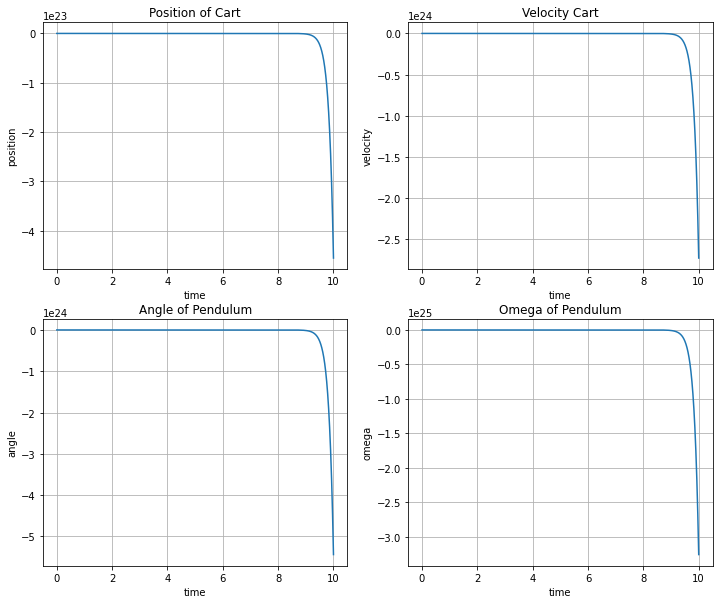

In [35]:
Plot_state(x,dx,th,dth,ts)

<h3> Pendulum control using PID

In [21]:
class DiscreteController:
    def __init__(self, DeltaT, Kp, Ki,Kd):
        self.DeltaT = DeltaT
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.next_sample_time = 0
        self.cumError =  0.0
        self.rateError = 0.0
        self.lastError = 0.0
        self.output =    0.0

    def update(self, u, t):
        if t >= self.next_sample_time:
            self.cumError += u*self.DeltaT
            self.rateError = (u-self.lastError)/self.DeltaT
            self.output = self.Kp*u + self.Ki*self.cumError + self.Kd*self.rateError
            self.next_sample_time += self.DeltaT
            self.lastError = u

In [22]:
def control_simulation_pid(pendulum,controller_angle,controller_velocity):
    theta = []
    position = []
    velocity = []
    omega = []
    for t in ts:
        pendulum.change_input(controller_angle.output+controller_velocity.output)
        error_a = ref_angle - pendulum.output[2]
        error_v = ref_velocity - pendulum.output[1]
        controller_angle.update(error_a,t)
        controller_velocity.update(error_v,t)
        pendulum.change_state(pendulum.state + pendulum.derivative(controller_angle.output+ controller_velocity.output)*dt)
    
        position.append(pendulum.output[0])
        velocity.append(pendulum.output[1])
        theta.append(pendulum.output[2])
        omega.append(pendulum.output[3])
        
    return np.array([position, velocity,theta,omega])

In [23]:
sample_time = 10/1000
ref_angle = 0.0
ref_velocity = 0.0
ts = np.arange(0, 10, 10**(-3))
dt = ts[1]

In [24]:

th_controller = DiscreteController(DeltaT=sample_time, Kp=100, Ki=80, Kd=1)
v_controller = DiscreteController(DeltaT=sample_time, Kp = -0.1, Ki= 0.8, Kd=0.025)
pendulum = Pendulum_Linear(A,B,C,D)
x,dx,th,dth = control_simulation_pid(pendulum,th_controller,v_controller)

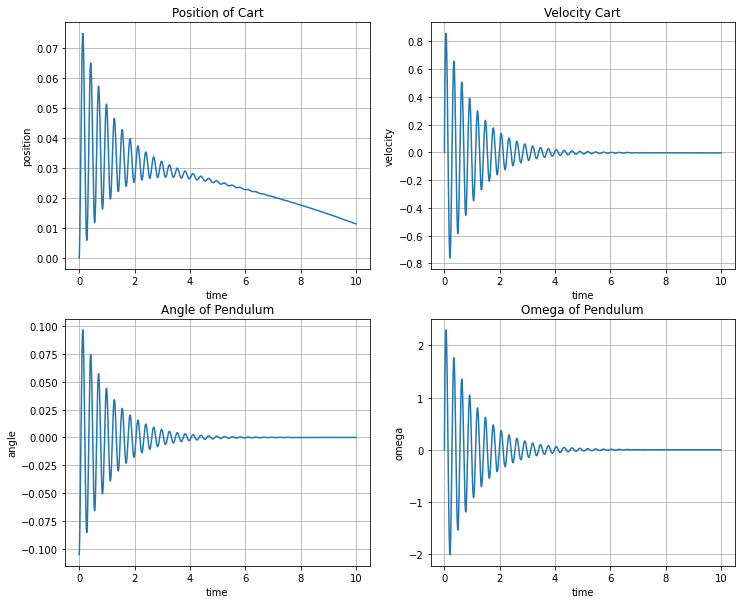

In [25]:
Plot_state(x,dx,th,dth,ts)

<h3> Control with LQR method using State estimation with Kalman Filter</h3>

Lets apply to non linear model of inverted pendulum and estimate with linearize model

In [27]:
from control.matlab import acker

In [28]:
def control_simulation_Kalman(pendulum):
    sys = control.ss(A,B,C,D)
    Q = np.array([[1,0,0,0],
                   [0,1,0,0],
                   [0,0,2,0],
                   [0,0,0,1]])
    R = 1
    K, S, E = control.lqr(sys, Q, R)
    L = acker(A,B,E)

    ref_state = np.array([[0.0],[0.0],[0.0],[0.0]])
    x_est = np.array([[0.0],[0.0],[0.0],[0.0]])
    pendulum.change_input(0.0)
    x_meas = np.array([[0.0],[0.0],[0.0],[0.0]])
    theta = []
    position = []
    velocity = []
    omega = []
    x_pre = []
    for t in ts:
        
        th_meas = pendulum.output[2]
        x_meas[2,0]= th_meas
        x_est[2,0] = th_meas
        state_error = ref_state - x_est
        #print(state_error)

        x_est = (np.matmul(A,x_est) + B*np.dot(K[0],state_error).sum()  + np.matmul(L, x_meas-np.matmul(C,x_est)))*dt +x_est
        x_pre.append(np.matmul(C,x_est)[0,0])
        control_output = B*np.dot(K[0],state_error).sum()
        #print(control_output)

        pendulum.change_input(control_output)
        pendulum.change_state(pendulum.state + pendulum.derivative(control_output)*dt)
        x_meas = x_est
    
        position.append(pendulum.output[0])
        velocity.append(pendulum.output[1])
        theta.append(pendulum.output[2])
        omega.append(pendulum.output[3])
        
    return np.array([position, velocity,theta,omega,x_pre])

In [29]:
sample_time = 10/1000
ref_angle = 0.0
ref_velocity = 0.0
ts = np.arange(0, 50, 10**(-3))
dt = ts[1]

In [30]:
pendulum = Pendulum_Linear(A,B,C,D)
x,dx,th,dth,x_pre  = control_simulation_Kalman(pendulum)

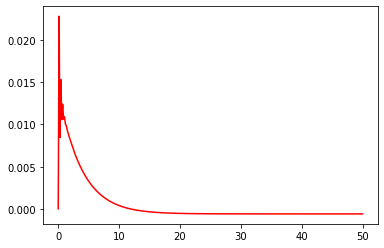

In [31]:
plt.plot(ts,x,"r")
#plt.xlim((0,3))

array([0.   , 0.002])